# League of Legends — Group EDA Notebook

This notebook explores match and participant data produced by the ETL pipeline and `build_group_view.py`.

It covers:
- Data loading & sanity checks  
- Overall summaries (matches, players, queues, patches)  
- Per-player win rates and volumes  
- Champion performance & **lift** (Pick Advisor logic)  
- Rolling win-rate trend for a selected player  
- **Contribution** (with/without) analysis  
- Queue and patch comparisons  

In [1]:
# --- Robust project-aware loader for LoL data ---
import os, glob
from pathlib import Path
import pandas as pd

def find_project_root(start: Path) -> Path:
    """Walk up until we find a folder that looks like the repo (has data/ or src/ or app/)."""
    for p in [start, *start.parents]:
        if (p / "data").exists() or (p / "src").exists() or (p / "app").exists():
            return p
    return start

def newest(patterns, root: Path) -> str | None:
    """Return the newest matching file among a list of glob patterns (relative to root)."""
    hits = []
    for pat in patterns:
        hits.extend(glob.glob(str(root / pat), recursive=True))
    if not hits:
        return None
    # pick the most recently modified file
    hits.sort(key=lambda p: Path(p).stat().st_mtime, reverse=True)
    return hits[0]

# 1) Resolve project root & data dir
CWD = Path.cwd()
PROJECT_ROOT = find_project_root(CWD)
DATA = PROJECT_ROOT / "data"
print("cwd         :", CWD)
print("project root:", PROJECT_ROOT)
print("data folder :", DATA, "(exists:", DATA.exists(), ")")

# 2) Choose participants file (prefer *_group_latest, else newest participants_*.parquet)
participants_path = (
    newest(["data/participants_group_latest.parquet"], PROJECT_ROOT)
    or newest(["data/participants_*.parquet", "data/*participants*.parquet"], PROJECT_ROOT)
)

# 3) Choose matches file (prefer *_latest, else newest matches_*.parquet)
matches_path = (
    newest(["data/matches_latest.parquet"], PROJECT_ROOT)
    or newest(["data/matches_*.parquet"], PROJECT_ROOT)
)

print("participants parquet =>", participants_path)
print("matches parquet      =>", matches_path)

if not participants_path or not matches_path:
    raise FileNotFoundError(
        "Could not find required parquet files.\n"
        "Expected in <project>/data/: participants_* and matches_*.\n"
        "Run ETL + build_group_view.py or place files in data/."
    )

# 4) Load
pp = pd.read_parquet(participants_path)
pm = pd.read_parquet(matches_path)
print("Loaded shapes:", pp.shape, pm.shape)

# 5) Minimal prep (timezone & types)
pp["game_creation"] = pd.to_datetime(pp["game_creation"], errors="coerce", utc=True)
try:
    pp["game_creation_local"] = pp["game_creation"].dt.tz_convert("America/New_York")
except Exception:
    pp["game_creation_local"] = pp["game_creation"]
pp["date"] = pp["game_creation_local"].dt.date
if pp["win"].dtype not in ("int64","Int64"):
    pp["win"] = pp["win"].astype(bool).astype(int)
pp["player_label"] = (
    pp.get("player_label")
      .fillna(pp.get("summoner_name"))
      .replace({"None": None})
      .fillna("(unknown)")
)

cwd         : C:\Users\Josh Mondragon\Desktop\fall_25\projects\lol-ds\notebooks
project root: C:\Users\Josh Mondragon\Desktop\fall_25\projects\lol-ds
data folder : C:\Users\Josh Mondragon\Desktop\fall_25\projects\lol-ds\data (exists: True )
participants parquet => C:\Users\Josh Mondragon\Desktop\fall_25\projects\lol-ds\data\participants_group_latest.parquet
matches parquet      => C:\Users\Josh Mondragon\Desktop\fall_25\projects\lol-ds\data\matches_latest.parquet
Loaded shapes: (2180, 21) (218, 8)


In [5]:
from pathlib import Path
import pandas as pd

# Option 1: if build_group_view already created an "in_group" flag — use it
if "in_group" in pp.columns:
    before = len(pp)
    pp = pp[pp["in_group"] == True].copy()
    print(f"Filtered with in_group flag: {before} → {len(pp)} rows")

# Option 2: otherwise, read roster.csv and filter by riot_id
else:
    roster_path = Path(PROJECT_ROOT) / "data" / "roster.csv"
    if roster_path.exists():
        roster = pd.read_csv(roster_path)
        group_ids = set(roster["riot_id"].dropna().str.strip())
        before = len(pp)
        # keep rows whose player_label matches a known riot_id
        pp = pp[pp["player_label"].isin(group_ids)].copy()
        print(f"Filtered with roster.csv: {before} → {len(pp)} rows (players={len(group_ids)})")
    else:
        print("Warning: no in_group column and data/roster.csv not found; cannot filter to your group.")

# (Optional) extra guard: only keep labels that look like Riot IDs (contain '#')
before2 = len(pp)
pp = pp[pp["player_label"].astype(str).str.contains("#")].copy()
print(f"Applied '#'-guard: {before2} → {len(pp)} rows")

# Recompute quick sanity
print("Players:", pp['player_label'].nunique(), "Matches:", pp['match_id'].nunique())


Filtered with in_group flag: 2180 → 626 rows
Applied '#'-guard: 626 → 626 rows
Players: 14 Matches: 218


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 130

print("Rows:", len(pp), "Cols:", pp.shape[1])
print("Players:", pp['player_label'].nunique(), "Matches:", pp['match_id'].nunique())
print("Queues:", sorted(pp['queue'].dropna().unique().tolist()))
print("Date range:", pp['date'].min(), "→", pp['date'].max())
pp.head(3)


Rows: 626 Cols: 23
Players: 14 Matches: 218
Queues: [400]
Date range: 2024-12-24 → 2025-09-15


,match_id,puuid,riot_id,player_label,in_group,summoner_name,champion,role,lane,win,...,cs,gold,vision_score,damage_dealt,time_ccing,game_creation,game_version,queue,game_creation_local,date
0,NA1_5368950641,ZJivU2RN47s5J0wyp47MVfJoySqHj5qKkW0yA20y63U2DI...,Ikkyro#NA1,Ikkyro#NA1,True,,Malphite,SOLO,TOP,1,...,180,12745,14,22385,31,2025-09-15 05:44:27.775000+00:00,15.18.710.2811,400,2025-09-15 01:44:27.775000-04:00,2025-09-15
2,NA1_5368950641,lcESRJ_biw7ITJgedGPd1T5VE5GFkjX0X7YmzEn7myuTgg...,sun#034,sun#034,True,,Yasuo,SOLO,MIDDLE,1,...,146,9401,14,6954,7,2025-09-15 05:44:27.775000+00:00,15.18.710.2811,400,2025-09-15 01:44:27.775000-04:00,2025-09-15
3,NA1_5368950641,oyWCHYS5uW2J_9Wvu5dLlBvgb0E7n8bGTIYfqI7nvjbYHP...,kingslayer#LBJ,kingslayer#LBJ,True,,Xayah,CARRY,BOTTOM,1,...,259,18420,13,50630,23,2025-09-15 05:44:27.775000+00:00,15.18.710.2811,400,2025-09-15 01:44:27.775000-04:00,2025-09-15


C:\Users\Josh Mondragon\AppData\Local\Temp\ipykernel_19292\1182553053.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=plot_df.index, x=plot_df["winrate"], palette="crest")


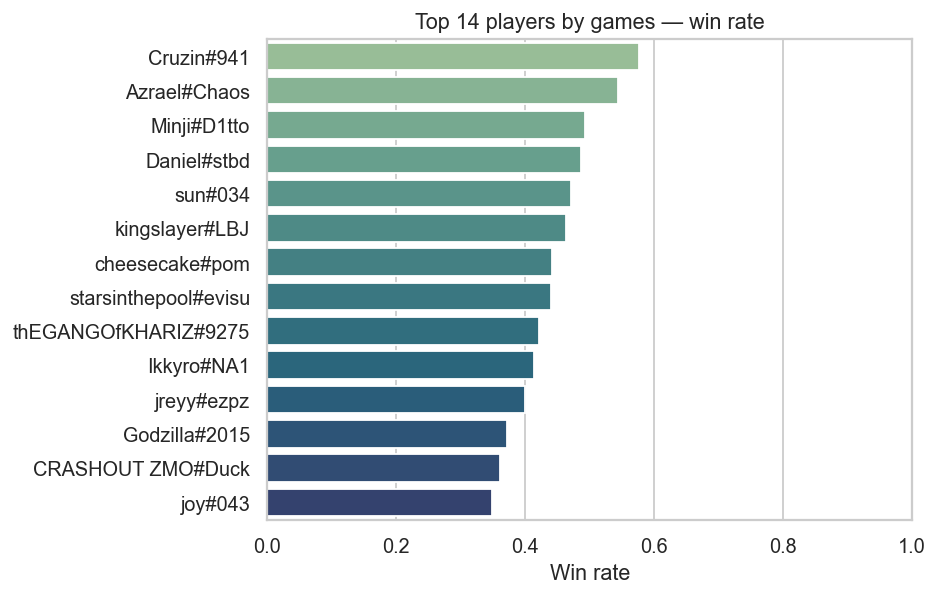

,games,winrate
player_label,,
sun#034,102,0.470588
Azrael#Chaos,68,0.544118
Minji#D1tto,61,0.491803
joy#043,46,0.347826
Ikkyro#NA1,46,0.413043
Godzilla#2015,43,0.372093
cheesecake#pom,43,0.441860
kingslayer#LBJ,41,0.463415
thEGANGOfKHARIZ#9275,38,0.421053


In [9]:
player_summary = (
    pp.groupby("player_label")
      .agg(games=("win","size"), winrate=("win","mean"))
      .sort_values("games", ascending=False)
)

topN = 20
plot_df = player_summary.head(topN).sort_values("winrate", ascending=False)

ax = sns.barplot(y=plot_df.index, x=plot_df["winrate"], palette="crest")
ax.set(xlabel="Win rate", ylabel=None, xlim=(0,1), title=f"Top {len(plot_df)} players by games — win rate")
plt.show()

player_summary.head(10)


In [10]:
# player baseline
base = pp.groupby("player_label")["win"].mean().rename("base")

# champion stats
champ = (pp.groupby(["player_label","champion"])
           .agg(games=("win","size"), winrate=("win","mean"))
           .reset_index()
        ).merge(base, on="player_label", how="left")
champ["lift"] = champ["winrate"] - champ["base"]

# filter & preview
min_games = 5
champ_filt = champ[champ["games"] >= min_games].copy()
champ_filt.sort_values(["player_label","lift"], ascending=[True, False]).head(12)


,player_label,champion,games,winrate,base,lift
4,Azrael#Chaos,Mel,5,0.600000,0.544118,0.055882
8,Azrael#Chaos,Veigar,5,0.600000,0.544118,0.055882
6,Azrael#Chaos,Twitch,37,0.540541,0.544118,-0.003577
2,Azrael#Chaos,Lillia,14,0.500000,0.544118,-0.044118
10,CRASHOUT ZMO#Duck,Nunu,10,0.500000,0.360000,0.140000
15,CRASHOUT ZMO#Duck,Warwick,6,0.333333,0.360000,-0.026667
17,Cruzin#941,Brand,5,0.800000,0.576923,0.223077
22,Cruzin#941,Varus,7,0.571429,0.576923,-0.005495
18,Cruzin#941,Caitlyn,7,0.142857,0.576923,-0.434066
25,Daniel#stbd,Mordekaiser,5,0.800000,0.486486,0.313514


In [11]:
# player baseline
base = pp.groupby("player_label")["win"].mean().rename("base")

# champion stats
champ = (pp.groupby(["player_label","champion"])
           .agg(games=("win","size"), winrate=("win","mean"))
           .reset_index()
        ).merge(base, on="player_label", how="left")
champ["lift"] = champ["winrate"] - champ["base"]

# filter & preview
min_games = 5
champ_filt = champ[champ["games"] >= min_games].copy()
champ_filt.sort_values(["player_label","lift"], ascending=[True, False]).head(12)


,player_label,champion,games,winrate,base,lift
4,Azrael#Chaos,Mel,5,0.600000,0.544118,0.055882
8,Azrael#Chaos,Veigar,5,0.600000,0.544118,0.055882
6,Azrael#Chaos,Twitch,37,0.540541,0.544118,-0.003577
2,Azrael#Chaos,Lillia,14,0.500000,0.544118,-0.044118
10,CRASHOUT ZMO#Duck,Nunu,10,0.500000,0.360000,0.140000
15,CRASHOUT ZMO#Duck,Warwick,6,0.333333,0.360000,-0.026667
17,Cruzin#941,Brand,5,0.800000,0.576923,0.223077
22,Cruzin#941,Varus,7,0.571429,0.576923,-0.005495
18,Cruzin#941,Caitlyn,7,0.142857,0.576923,-0.434066
25,Daniel#stbd,Mordekaiser,5,0.800000,0.486486,0.313514


C:\Users\Josh Mondragon\AppData\Local\Temp\ipykernel_19292\3982877770.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=pl["champion"], x=pl["lift"], palette="viridis")


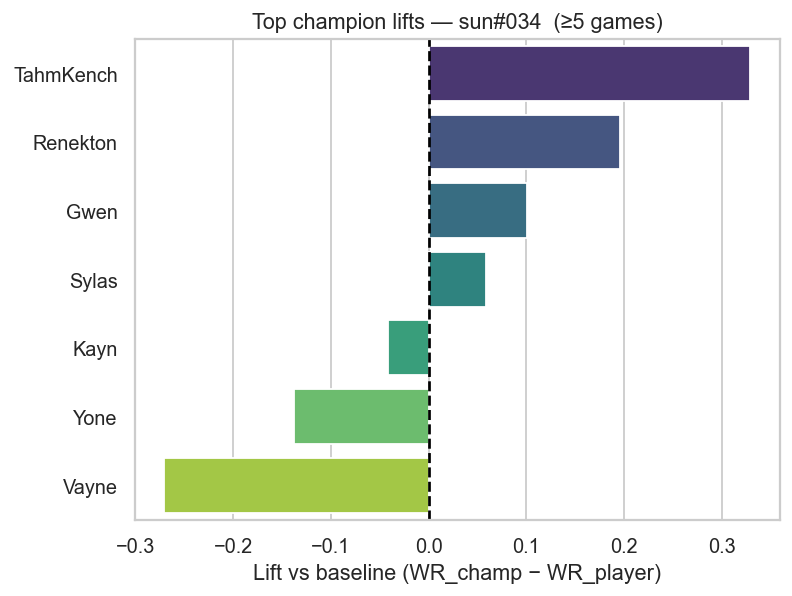

In [22]:
sel_player = champ_filt["player_label"].mode().iloc[0]
pl = champ_filt[champ_filt["player_label"]==sel_player].sort_values("lift", ascending=False).head(10)

ax = sns.barplot(y=pl["champion"], x=pl["lift"], palette="viridis")
plt.axvline(0, color="black", ls="--")
ax.set(xlabel="Lift vs baseline (WR_champ − WR_player)", ylabel=None,
       title=f"Top champion lifts — {sel_player}  (≥{min_games} games)")
plt.show()


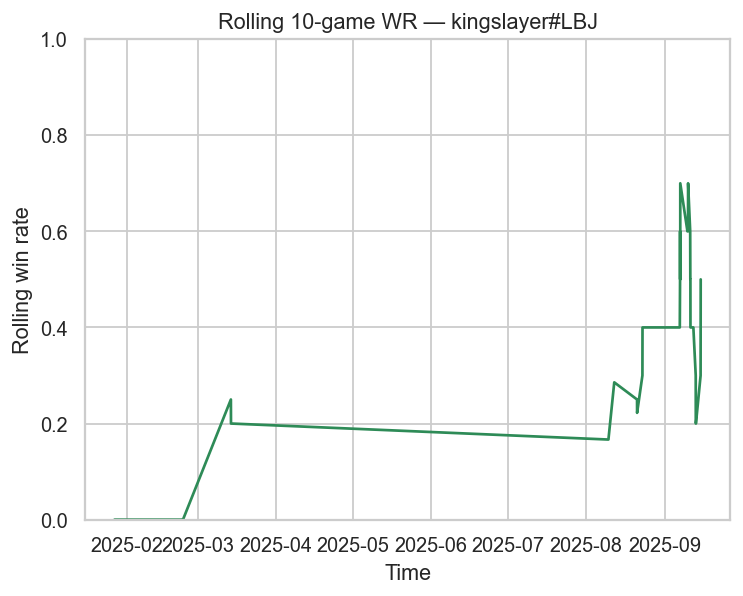

In [18]:
player_for_trend = "kingslayer#LBJ"  # or e.g., "Ikkyro#NA1"
window = 10

tdf = (pp[pp["player_label"]==player_for_trend]
         .sort_values("game_creation_local")
         .assign(rolling_wr=lambda d: d["win"].rolling(window, min_periods=1).mean())
      )

ax = sns.lineplot(data=tdf, x="game_creation_local", y="rolling_wr", color="#2E8B57")
ax.set(ylabel="Rolling win rate", xlabel="Time", title=f"Rolling {window}-game WR — {player_for_trend}", ylim=(0,1))
plt.show()


In [23]:
scores = []
for pl in sorted(pp["player_label"].unique()):
    with_pl = pp[pp["player_label"]==pl]
    g = len(with_pl)
    if g == 0:
        continue
    mids_with = set(with_pl["match_id"].unique())
    wr_with = with_pl["win"].mean()
    wr_without = pp.loc[~pp["match_id"].isin(mids_with), "win"].mean()
    contribution = wr_with - wr_without
    scores.append({"player": pl, "games": g, "wr_with": wr_with, "wr_without": wr_without, "contribution": contribution})

contrib = (pd.DataFrame(scores)
             .dropna()
             .assign(weighted=lambda d: d["contribution"] * np.sqrt(d["games"]))
             .sort_values("weighted", ascending=False)
          )
contrib.head(10)


,player,games,wr_with,wr_without,contribution,weighted
0,Azrael#Chaos,68,0.544118,0.397183,0.146935,1.211653
2,Cruzin#941,26,0.576923,0.429630,0.147293,0.751052
12,sun#034,102,0.470588,0.432314,0.038274,0.386547
6,Minji#D1tto,61,0.491803,0.443418,0.048385,0.377901
3,Daniel#stbd,37,0.486486,0.434694,0.051793,0.315042
10,kingslayer#LBJ,41,0.463415,0.454148,0.009266,0.059332
11,starsinthepool#evisu,25,0.440000,0.451977,-0.011977,-0.059887
7,cheesecake#pom,43,0.441860,0.459350,-0.017489,-0.114684
13,thEGANGOfKHARIZ#9275,38,0.421053,0.461224,-0.040172,-0.247636
9,jreyy#ezpz,25,0.400000,0.458410,-0.058410,-0.292052


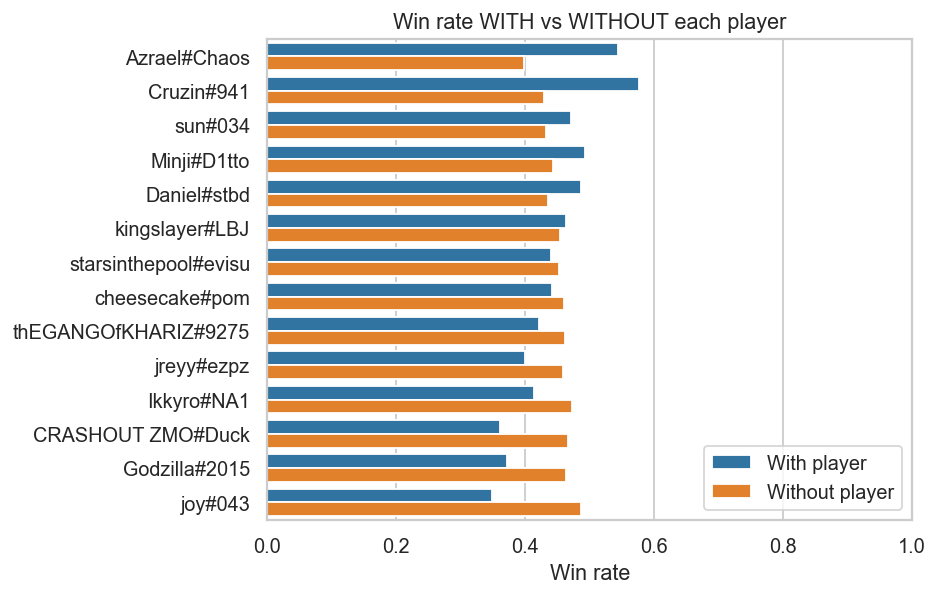

In [26]:
wr_long = contrib.melt(id_vars=["player","games"], value_vars=["wr_with","wr_without"],
                       var_name="type", value_name="winrate")
wr_long["type"] = wr_long["type"].map({"wr_with":"With player", "wr_without":"Without player"})

# keep players ordered by impact
order = contrib["player"].tolist()
wr_long["player"] = pd.Categorical(wr_long["player"], categories=order, ordered=True)

ax = sns.barplot(data=wr_long, x="winrate", y="player", hue="type", palette=["#1f77b4","#ff7f0e"])
ax.set(xlabel="Win rate", ylabel=None, xlim=(0,1), title="Win rate WITH vs WITHOUT each player")
plt.legend(title=None, loc="lower right")
plt.show()


In [30]:
# queue split (400 normals vs 420 ranked)
qq = pp.groupby(["player_label","queue"])["win"].mean().reset_index()
pivot = qq.pivot(index="player_label", columns="queue", values="win").rename(columns={400:"Normals Win_Rate"})
pivot.head(15)

queue,Normals Win_Rate
player_label,
Azrael#Chaos,0.544118
CRASHOUT ZMO#Duck,0.360000
Cruzin#941,0.576923
Daniel#stbd,0.486486
Godzilla#2015,0.372093
Ikkyro#NA1,0.413043
Minji#D1tto,0.491803
cheesecake#pom,0.441860
joy#043,0.347826
